<a href="https://colab.research.google.com/github/vitroid/PythonTutorials/blob/master/2%20Advanced/055MolSym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分子シミュレーション

ここでは、分子シミュレーションに関連したコーディング技法をいろいろ示します。分子シミュレーションそのものについては、教科書等を参考にして下さい。

In [1]:
import numpy as np

## 1. 原子の座標

原子の座標は$3\times N$次元のnp.arrayで表現すると、あとあと便利です。ここでは例として、$50^3$単純立方格子の座標を生成します。原子間距離は2.5 Åとします。



### 1.1 単純ループ

In [2]:
%%timeit

N = 50
d = 2.5
atoms = []
for ix in range(N):
    for iy in range(N):
        for iz in range(N):
            atoms.append([ix*d, iy*d, iz*d])
atoms = np.array(atoms)


102 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1.2 リスト内包記法

In [3]:
%%timeit

N = 50
d = 2.5
atoms = np.array([(ix*d, iy*d, iz*d) for ix in range(N) for iy in range(N) for iz in range(N)])


105 ms ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


numpyのベクトル演算を使いましょう。かけ算はあとでまとめて行います。

In [29]:
%%timeit

N = 50
d = 2.5
atoms = d * np.array([(ix, iy, iz) for ix in range(N) for iy in range(N) for iz in range(N)]) 


62.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1.3 np.arangeを使う

range()は整数しか扱えないので、実数版であるnp.arangeに代えます。ixなどのループ専用変数が要らなくなる分、直接的な表現といえます。

In [4]:
%%timeit

N = 50
d = 2.5
atoms = []
for x in np.arange(0, N*d, d):
    for y in np.arange(0, N*d, d):
        for z in np.arange(0, N*d, d):
            atoms.append([x, y, z])
atoms = np.array(atoms)

98.3 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


一般に、リスト内包記法は通常のループよりも高速です。

In [5]:
%%timeit

N = 50
d = 2.5
atoms = np.array([(x,y,z) for x in np.arange(0, N*d, d) for y in np.arange(0, N*d, d) for z in np.arange(0, N*d, d)])


78.7 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1.4 meshgridを使う

numpyには、格子を生成するための特別な関数がいくつかあります。meshgridは、X,Y,Z軸方向の目盛から、格子点を一気に生成します。

まず、X方向の目盛を作ります。

In [7]:
N = 50
d = 2.5
X = np.arange(0, N*d, d)
X

array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
        45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
       112.5, 115. , 117.5, 120. , 122.5])

同様に、Y, Zも生成し、これらを組みあわせてグリッド(格子)を作ります。

In [17]:
Y = np.arange(0, N*d, d)
Z = np.arange(0, N*d, d)

Xg,Yg,Zg = np.meshgrid(X,Y,Z, indexing="ij")
Xg

array([[[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]],

       [[  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        ...,
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
        [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5]],

       [[  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        [  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        [  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        ...,
        [  5. ,   5. ,   5. , ...,   5. ,   5. ,   5. ],
        [  5. ,   5. ,   5. , ...,   5. ,   5

Xgの中身は、Xの内容がなんどもリピートされているように見えます。しかも3次元配列ですね。では、個々の要素を見ていきます。

In [18]:
Xg[0,0,0], Yg[0,0,0], Zg[0,0,0]

(0.0, 0.0, 0.0)

In [19]:
Xg[3,2,4], Yg[3,2,4], Zg[3,2,4]

(7.5, 5.0, 10.0)

わかるでしょうか。`Xg[i,j,k]`には、$(i,j,k)$番目の格子点のX座標が入っています。

三次元配列ではなく、以前の例のような座標の単純な羅列が欲しいなら、flatten()関数で1次元化します。

In [20]:
Xf = Xg.flatten()
Yf = Yg.flatten()
Zf = Zg.flatten()
Xf.shape

(125000,)

全部まとめると次のように書けます。

In [27]:
%%timeit

N = 50
d = 2.5
X = np.arange(0, N*d, d)
Y = np.arange(0, N*d, d)
Z = np.arange(0, N*d, d)
Xg, Yg, Zg = np.meshgrid(X,Y,Z)
Xf = Xg.flatten()
Yf = Yg.flatten()
Zf = Zg.flatten()
atoms = np.array([Xf,Yf,Zf]).T


1.32 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


読みにくくなりますが、ループがまったくないので爆速です。

さらに直感的でない方法として、mgridを使う方法があります。mgridはmeshgridと似た働きをしますが、関数ではなく配列のように見えます。

In [34]:
%%timeit 

N = 50
d = 2.5
Xg, Yg, Zg = np.mgrid[0:N,0:N,0:N]
Xf = Xg.flatten()
Yf = Yg.flatten()
Zf = Zg.flatten()
atoms = d * np.array([Xf,Yf,Zf]).T


4.34 ms ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


極限まで簡略化するとこんな感じ。もはや読めませんが、関数にして名前をつけておけば無問題です。

In [42]:
%%timeit

def simple_lattice(N):
    """最近接原子間距離が1の単純立方格子を生成する。

    N: 単位胞をN^3個生成する
    """
    return np.mgrid[0:N, 0:N, 0:N].reshape(3,-1).T

N = 50
d = 2.5
atoms = simple_lattice(N)*d


1.66 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)



### 1.5 ほかの格子

面心立方格子は、単純立方格子を$(1/2, 1/2, 1/2)$だけずらして重ねたものといえます。

まず、間隔1の単純格子をつくります。

In [44]:
def simple_lattice(N):
    """最近接原子間距離が1の単純立方格子を生成する。

    N: 単位胞をN^3個生成する
    """
    return np.mgrid[0:N, 0:N, 0:N].reshape(3,-1).T

N = 50
atoms = simple_lattice(N)
atoms

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [49, 49, 47],
       [49, 49, 48],
       [49, 49, 49]])

ずらした格子を別途作ります。

In [45]:
slid = atoms + np.array([0.5, 0.5, 0.5])
slid

array([[ 0.5,  0.5,  0.5],
       [ 0.5,  0.5,  1.5],
       [ 0.5,  0.5,  2.5],
       ...,
       [49.5, 49.5, 47.5],
       [49.5, 49.5, 48.5],
       [49.5, 49.5, 49.5]])

そして2つを連結concatします。

In [48]:
bcc = np.concatenate([atoms, slid])
bcc

最近接格子間距離を2.5 Åにしたいなら、ちょっと工夫が必要です。最近接原子は$(0,0,0)$と$(1/2,1/2,1/2)$にあります。この距離が2.5 Åになるように調節します。

In [50]:
d = 2.5
bcc * d * 2 / 3**0.5

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   2.88675135],
       [  0.        ,   0.        ,   5.77350269],
       ...,
       [142.89419162, 142.89419162, 137.12068893],
       [142.89419162, 142.89419162, 140.00744028],
       [142.89419162, 142.89419162, 142.89419162]])

最後に、これも関数にしておきます。

In [52]:
def BCC(N):
    """最近接原子間距離が1の体心立方格子を生成する。

    N: 単位胞をN^3個生成する
    """
    atoms = simple_lattice(N)
    slid = atoms + np.array([0.5, 0.5, 0.5])
    return np.concatenate([atoms, slid]) * 2 / 3**0.5

N = 50
d = 2.5
atoms = BCC(N) * d
atoms

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   2.88675135],
       [  0.        ,   0.        ,   5.77350269],
       ...,
       [142.89419162, 142.89419162, 137.12068893],
       [142.89419162, 142.89419162, 140.00744028],
       [142.89419162, 142.89419162, 142.89419162]])

関数定義の直後にある文字列は、関数の説明文です。これを定義しておくと、ヘルプに表示されます。

In [53]:
?BCC

### 1.99 練習問題

単位格子数$2^3$で最短原子間距離が2.5 Åの最密充填格子を作って下さい。

## シミュレーションセルの取扱い

分子シミュレーションはほとんどの場合周期境界条件のもとで行われます。周期境界条件を適用しない場合、必ず表面の影響を受けてしまいますが、周期境界条件により表面のない状況を擬似的に表現できます。

分子シミュレーションでは、分子の入っている箱のことをシミュレーションセルまたは単にセルと呼びます。セルは立方体の場合もあれば直方体の場合もあります。気体や液体のシミュレーションでは立方体セルを使うことが多いですが、固体の場合には結晶の形によっては直方体や平行六面体のセルを用いる場合もあります。

セルの大きさについてはここでは議論しませんが、あまり小さな系はアーティファクトの原因になります。最近では1万分子以上を含むような、大規模なシミュレーションも一般的になってきています。

以下ではシミュレーションセルは一般的に平行六面体であると考え、その3つの辺を$(\vec a, \vec b, \vec c)$あるいは`a,b,c`で表記します。

### 1.1 絶対座標系とセル相対座標系

セル内の原子の座標を表す方法として、絶対座標(ユークリッド座標)を指定する方法と、セル相対座標(fractional coordinate)を指定する方法があります。

例えば、一辺が12 Åのシミュレーションセルのすみ(原点)と、中央にいる原子の座標は、絶対座標では$(0,0,0), (6,6,6)$、セル相対座標では$(0,0,0), (0.5, 0.5, 0.5)$となります。

直感的にわかりやすいのは前者ですが、周期境界条件のとりあつかいを考えると、後者のほうが圧倒的に便利です。

直方体セルの場合、セル相対座標を絶対座標に変換するには、セル長をかけます。逆に、絶対座標をセル長で割れば、セル相対座標になります。

In [54]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
B = np.array([6.0, 6.0, 6.0])

rA = A / cell
rB = B / cell
rA, rB

(array([0., 0., 0.]), array([0.5, 0.5, 0.5]))

### 1.2 周期境界条件下での原子間距離の計算

2つの原子の距離は、座標からピタゴラスの定理を使って計算できます。

In [58]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
B = np.array([3.0, 3.0, 3.0])

dAB = B - A
r = (dAB[0]**2 + dAB[1]**2 + dAB[2]**2)**0.5
r

5.196152422706632

でも、次の場合にはこの方法はうまくいきません。

In [59]:
A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

dAC = C - A
r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

15.588457268119896

周期境界条件のもとでは、AB間の距離はAC間の距離と同じはずですが、AC間の計算ではイメージセル間の最短距離をとらえそこねています。

ちゃんと計算するには、条件分岐が必要になります。

In [60]:
A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

dAC = C - A

if dAC[0] < -6.0:
    dAC[0] += 12
elif dAC[0] > +6.0:
    dAC[0] -= 12

if dAC[1] < -6.0:
    dAC[1] += 12
elif dAC[1] > +6.0:
    dAC[1] -= 12

if dAC[2] < -6.0:
    dAC[2] += 12
elif dAC[2] > +6.0:
    dAC[2] -= 12

r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

5.196152422706632

これは面倒臭い! 上の条件式にでてくる6.0はセルの一辺の長さの半分です。差が6を越えたら、反対側のイメージセルの原子のほうが近いので、12を引いてイメージセルの原子との距離におきかえます。これを3方向について処理する必要があります。

次に、同じことをセル相対座標で書いてみます。

In [61]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

# to a fractional coordinate
rA = A / cell
rC = C / cell

dAC = rC - rA

if dAC[0] < -0.5:
    dAC[0] += 1
elif dAC[0] > +0.5:
    dAC[0] -= 1

if dAC[1] < -0.5:
    dAC[1] += 1
elif dAC[1] > +0.5:
    dAC[1] -= 1

if dAC[2] < -0.5:
    dAC[2] += 1
elif dAC[2] > +0.5:
    dAC[2] -= 1

# to an absolute displacement vector
dAC *= cell

r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

5.196152422706632

やっていることは同じですが、セルサイズが条件文の中にでてこなくなったので、すこし見易くなりました。

でもメリットはこれだけではありません。条件文の計算は、実は「四捨五入」と等価なのです。例えば、`x==0.75`なら、上の条件文を通ると`x==-0.25`になりますよね。これは、「xを小数点1桁目で四捨五入して、xから引く」のと同じ結果になります。

numpyには四捨五入関数round()が準備されていますから、これを使うとプログラムはさっぱりします。

In [62]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([0.0, 0.0, 0.0])
C = np.array([9.0, 9.0, 9.0])

# fractional coordinate
rA = A / cell
rC = C / cell

dAC = rC - rA
dAC -= np.round(dAC)

# absolute displacement vector
dAC *= cell

r = (dAC[0]**2 + dAC[1]**2 + dAC[2]**2)**0.5
r

5.196152422706632

> なお、松本は`round()`関数の挙動が気持ち悪いので、`floor(x+0.5)`という書き方を好みます。`round()`の気持ち悪さは下のグラフで実感できます。

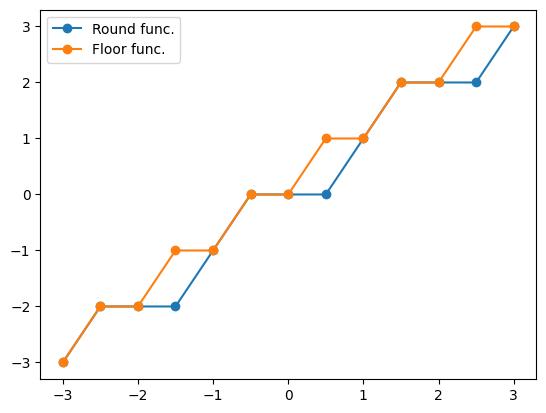

In [73]:
import matplotlib.pyplot as plt

x = np.arange(-3.0, +3.5, 0.5)
plt.plot(x, np.round(x), "o-",  label="Round func.")
plt.plot(x, np.floor(x+0.5), "o-", label="Floor func.")
plt.legend()


### 1.3 セルからはみでた原子の扱い

分子動力学シミュレーションの過程で、原子がセル端面を越えて外に出てしまう場合があります。その場合は、反対側から入ってきます。

絶対座標で書くと以下のような感じです。

In [74]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([1.0, 2.0, -3.0]) # z方向にはみ出している

if A[0] < 0.0:
    A[0] += 12
elif A[0] > 12:
    A[0] -= 12

if A[1] < 0.0:
    A[1] += 12
elif A[1] > 12:
    A[1] -= 12
    
if A[2] < 0.0:
    A[2] += 12
elif A[2] > 12:
    A[2] -= 12
    
A

array([1., 2., 9.])

これも、セル相対座標を使えばすこし簡潔になります。

In [75]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([1.0, 2.0, -3.0]) # z方向にはみ出している

# to a fractional coordinate
rA = A / cell

if rA[0] < 0.0:
    rA[0] += 1
elif rA[0] > 1:
    rA[0] -= 1

if rA[1] < 0.0:
    rA[1] += 1
elif rA[1] > 1:
    rA[1] -= 1
    
if rA[2] < 0.0:
    rA[2] += 1
elif rA[2] > 1:
    rA[2] -= 1

# to an absolute coordinate
A = rA * cell   
A

array([1., 2., 9.])

今度は条件分岐のしかたがちょっと違いますね。この条件分岐は、切り捨てに書きなおすことができます。

* zは-0.25。(-3/12)
* zを小数点以下で切り捨てる=zよりも小さい最大の整数にする=-1
* もとのzから-1を引くと0.75。



In [76]:
cell = np.array([12.0, 12.0, 12.0])

A = np.array([1.0, 2.0, -3.0]) # z方向にはみ出している

# to a fractional coordinate
rA = A / cell

# 切りすてた数をもとの数から引く。
rA -= np.floor(rA)

# to an absolute coordinate
A = rA * cell   
A

array([1., 2., 9.])

このように、セル相対座標を使うことで、条件分岐を使わないですみ、プログラムが簡潔かつ高速になります。

### 1.4 非直方体セルの取扱い

直方体でないセルのことも考えると、絶対座標よりセル相対座標のほうが圧倒的に便利であることがわかります。

直方体でないセルの、3つの辺をそれぞれ$\vec a, \vec b, \vec c$で表します。

さて、このセルの中央に原子をひとつ置いて下さい。もし絶対座標を使うのなら、中心とは$\vec a+ \vec b+ \vec c\over 2$のことです。

In [79]:
a = np.array([3.0, 0.0, 0.0])
b = np.array([1.5, 4.0, 0.0]) # bが傾いている
c = np.array([0.0, 0.0, 5.0])

A = (a+b+c)/2
A


array([2.25, 2.  , 2.5 ])

では、絶対座標で$(0.5, 2.0, 3.0)$にある原子Bは、このセルの中にありますか? それとも外にありますか? 外にある場合、周期境界条件のもとでセル内に移動させるならどこに来るでしょうか。

かなり面倒に見えてきましたね。そこでセル相対座標の出番です。

セル相対座標では、その名の通り、原子の場所はセルの中での相対位置で指示します。例えば、セルの中心は、セルの形がどんなであっても$(0.5, 0.5, 0.5)$です。そして、絶対座標になおしたいなら、
$0.5\vec a+0.5 \vec b+0.5\vec c$を計算すればいいだけです。

もっと簡単に書く方法を教えましょう。セルの3基本ベクトルを束ねた、セル行列というものを作ります。

$$M=\left(\begin{array}{c}
a_x&b_x&c_x\\
a_y&b_y&c_y\\
a_z&b_z&c_z
\end{array}\right)$$

そして、これにセル相対ベクトル$\vec v=(1/2,1/2,1/2)^T$をかけます。($^T$は転置を表します。$\vec v$は縦ベクトルです)
$$ \vec w=M\cdot \vec v$$
$$=\left({a_x+b_x+c_x\over 2}, {a_y+b_y+c_y\over 2}, {a_z+b_z+c_z\over 2}\right)$$

得られた$\vec w$はセル中心の絶対座標になっています!

ということは、逆に絶対座標に$M$の逆行列をかけるだけで、セル相対座標に変換できる、ということになります。

$$ \vec v=M^{-1}\cdot \vec w$$

なお、numpyでは座標ベクトルは横ベクトルで表されることが多いので、全部転置したほうが便利です。

$$ \vec w^T=\vec v^T\cdot M^T$$
$$ \vec v^T=\vec w^T\cdot (M^{-1})^T$$


In [80]:
Mt = np.array([a,b,c]) # 転置されたセル行列

vt = np.array([0.5,0.5,0.5])
wt = vt @ Mt
wt

array([2.25, 2.  , 2.5 ])

In [81]:
MtI = np.linalg.inv(Mt)

vt = wt @ MtI
vt

array([0.5, 0.5, 0.5])

セル相対座標表示のメリットはほかにもまだまだあります。

ある原子がセルからはみでているかどうかは、セル相対座標であれば、座標値が0〜1の範囲にあるかどうかだけで判別できます。

In [82]:
B = np.array([0.5,2.0,3.0]) #絶対座標
rB = B @ MtI
rB

array([-0.08333333,  0.5       ,  0.6       ])

Bはセル外にあります。では、周期境界条件を作用させて、セル内に移動させるには?

これも上で紹介した切り捨て法がそのまま使えます。

In [83]:
rB -= np.floor(rB)
rB

array([0.91666667, 0.5       , 0.6       ])

そして絶対座標に戻したければ、セル行列をかけます。

In [84]:
B = rB @ Mt
B

array([3.5, 2. , 3. ])

周期境界条件のもとでの2つの原子の相対ベクトルも、同じように簡単に計算できます。


In [85]:
B = np.array([0.5,2.0,3.0]) #絶対座標
rB = B @ MtI

rA = np.array([0.5,0.5,0.5]) # 相対座標でセルの中央

rel = rB - rA                # 相対座標での差
rel -= np.floor(rel+0.5)     # 相対座標での周期境界条件の作用

rel @ Mt  # 絶対座標における相対位置ベクトル

array([1.25, 0.  , 0.5 ])

Gromacsの.groファイルでは、原子座標を絶対座標で記録しますが、それが正しいというわけではありません。LAMMPSやCIFはセル相対座標を使います。周期境界条件に関係ある処理を行う場合は、原子の座標を全部セル相対座標に変換しておくと、何かと便利です。

groファイルを読みこみ、セル行列とセル相対座標を生成するMDAnalysisのサンプルコードを下に書いておきます。

In [ ]:
%pip install mdanalysis

In [86]:
import MDAnalysis as mda

with open("data.gro") as file:
    # MDAnalysisオブジェクト
    u = mda.Universe(file, format="GRO")
    # 酸素原子だけ抽出。単位はÅ 
    O = u.select_atoms("name OW")
    # 転置されたセル行列
    cell = mda.lib.mdamath.triclinic_vectors(u.trajectory.ts.dimensions).T
    # その逆行列
    celli = np.linalg.inv(cell)
    # 酸素原子の座標を抽出(絶対座標)
    pos = O.atoms.positions.astype(float)
    # セル相対座標に変換
    rpos = pos @ celli


SyntaxError: ignored